# Milestone project Food vision Big

## GOogle colab offers free GPU's (however not all of them are compatible with mix precisisioin training 
it offers 
* k80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

In order to use the mix precision we need the access of Tesla T4 from google colab (compute capability 7.0+)

# Getting the helper functions 
past modules created help function to do the small tasks for notebooks rather than rewriting we can import them 

In [ ]:
!nvidia-smi

Mon Jun  7 04:28:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-07 04:28:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-07 04:28:13 (63.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves,pred_and_plot,make_confusion_matrix,walk_through_dir,unzip_data,load_and_prep_image,create_tensorboard_callback

In [ ]:
import tensorflow as tf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Using the tensorflow datasets to download the data 
we are using the food 101 dataset for downloading the dataset 
there are many datasets available 

In [ ]:
dataset_list = tfds.list_builders()

In [ ]:
print('food101' in dataset_list)

True


In [ ]:
# loading in the data 
(train_data,test_data), ds_info = tfds.load(name = 'food101',
                                            split = ['train', 'validation'],
                                            shuffle_files = True,
                                            as_supervised = True, # data is in tuple data and label 
                                            with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIK3E6F/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIK3E6F/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# features of the food 101 from tsds 
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

## exploring the datasets 
the data is already converted into the tensors 
* class names 
* the shape of the input data 
* data type of the data 
* what do the labels look like 

In [ ]:
# getting the class names 
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
#taking the one sample of the data 
train_one_sample = train_data.take(1)

image shape :(384, 512, 3) 
 image dtype : <dtype: 'uint8'> 
 Target_class 97 
 class name = takoyaki


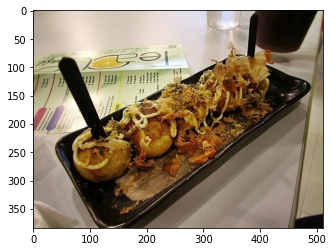

In [ ]:
for pic,label in train_one_sample:
  plt.imshow(pic)
  print(f'image shape :{pic.shape} \n image dtype : {pic.dtype} \n Target_class {label} \n class name = {class_names[label.numpy()]}')

pic shape (512, 384, 3) label 74 label shape (), labelname = peking_duck


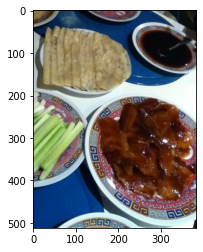

In [ ]:
for pic,label in train_one_sample:
  plt.imshow(pic)
  print(f'pic shape {pic.shape} label { label} label shape {label.shape}, labelname = {class_names[label.numpy()]}')

# Creating the preprocessing functions for our data 

Neural networks works best when the data in the certain way 
however the data is not come like ( batched , normalized ) 

In order to get it ready we have to write the preprocessing functoins and mapping it on the data 
* `uint8` datatype 
* comprised of different types of tensors 
* not scaled ( 0 and 255) 

what do we know about the models like 
* Data in `float32` dtype and `float16` datatype 
* for batches tensorflow like the batches to be of same size 
* Scaled also called as the normalized tensors perform generally better 

with these points in mind we 've got few things to do under the preprocessing function


since we're going to use efficientnetBx pretrained model rom tf.keras.applications we don't need to rescale our data the rescaling is bilt in inside them 

so fun need to 
1. reshape the images to all the same size 
2. convert the data into uint8 to float32 


In [ ]:
def preprocess_img(image,label,image_shape = 224):
  """
  Convert the image datatype to 'uint8' -> 'float32' and reshape image to [img_shape , img_shape, color channel]
  """
  image = tf.image.resize(image,[image_shape, image_shape]) # reshaping the target image 
  return tf.cast(image,tf.float32), label # return (float32 image , label)

In [ ]:
# Preprocess the single sampele and 
preprocessed_img = preprocess_img(pic,label)[0]

In [ ]:
print(f'image_before preprocessing {pic[:2]} \n {pic.shape} shape \n dataytpe {pic.dtype}')
print(f'pic after preprocessing {preprocessed_img[:2]} \n {preprocessed_img.shape} shape \n dataytpe {preprocessed_img.dtype}')



image_before preprocessing [[[152 129  77]
  [160 137  85]
  [160 137  85]
  ...
  [ 26  21  18]
  [ 24  19  16]
  [ 21  16  13]]

 [[156 133  81]
  [158 135  83]
  [155 132  80]
  ...
  [ 25  20  17]
  [ 23  18  15]
  [ 22  17  14]]] 
 (512, 384, 3) shape 
 dataytpe <dtype: 'uint8'>
pic after preprocessing [[[156.05103  133.05103   81.05102 ]
  [156.13776  133.13776   81.13776 ]
  [146.31122  123.311226  71.311226]
  ...
  [ 22.454105  17.454105  13.668401]
  [ 25.306135  20.306135  17.306135]
  [ 22.25511   17.25511   14.25511 ]]

 [[159.82652  136.82652   82.82653 ]
  [149.79591  126.79591   72.79591 ]
  [132.69388  109.69388   57.265305]
  ...
  [ 24.183672  19.183672  15.397966]
  [ 22.21425   17.21425   14.214251]
  [ 18.83164   14.83164   11.83164 ]]] 
 (224, 224, 3) shape 
 dataytpe <dtype: 'float32'>


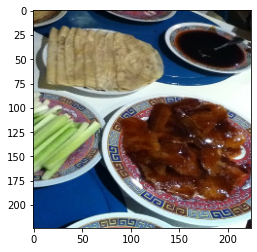

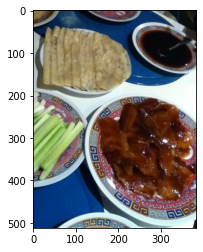

In [ ]:
plt.imshow(preprocessed_img/255.)
plt.figure()
plt.imshow(pic)

# batching and preprocessing the datasets 

we're now going to make teh data input pipeline fast 


In [ ]:
# map preprocessing function to training and parallellize it 
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size= 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# mapping preprocessing function to the test data 
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)#.cache() if there is more availabity of ram size in which the data can fit google colab is having not more of it so leave that thing 

In [ ]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> mapping the preprocessing funtion `preprocess_img` across the trainnign dtaset , then shuffle the number of the elements and then batch them together make sure you prepare new batches (prefetch ) while the model is looking for finiing pattern in teh current batch 


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.188
BogoMIPS:            4000.37
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

# creating the modelling callbacks 

we're going to create the couple of callbacks which will help us while the mdoels load 
* tensorboard callback 
* Model_checkpoint_callback_ to save teh model progress after feature extraction


In [ ]:
# create_ tensorboard 
from helper_functions import create_tensorboard_callback

# creating the model checkpoint callback to save model callbacks during training 
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,monitor='val_acc',
                                                      save_best = True,
                                                      save_weights_only = True, 
                                                      verbose = 1)



## setting up the mixed precision training 
tensorflow guile for the mixed precision training d

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_bfloat16') # on GPU mixed_float16


In [ ]:
# !pip install tensorflow==2.4.1

In [ ]:
#!pip install tensorflow==2.4.1 
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing 


input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape , name = 'input_layer') 
# note : efficient net bx model having the rescalign bhilt in we can have the layer like belwo 
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs,training = False) # make sure that the layers which are in training should stay untrainable 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype = tf.float32, name = 'softmax_float32')(x)
model = tf.keras.Model(inputs,outputs)
# compiling the model 
model.compile(
      loss = tf.keras.losses.sparse_categorical_crossentropy,
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy'],
      run_eagerly=False
)


TypeError: ignored

In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
  print(layer.name , layer.trainable, layer.dtype,layer.dtype_policy)

going through above we see 
* `layer.name ` human readable name of the layer 
* `layer.trainable`  is the layer trainable or not 
* `layer.dtype` layer storees theh variables in 
* `layer.dtype_policy` the dtype policy in which the layer computes in 

In [ ]:
# checking hte dtype policy of the layers in base model 
for layer in model.layers[1].layers:
  print(layer.name, layer.dtype, layer.dtype_policy,layer.trainable)

In [ ]:
# tf.compat.v1.enable_eager_execution()

model_history = model.fit(train_data,#eagar_mode = True,
                          steps_per_epoch = len(train_data),
                          epochs = 3 , 
                          callbacks = [model_checkpoint,create_tensorboard_callback('logs','food_bid_not_fine_tuned')],
                          validation_data = test_data, 
                          validation_steps = len(test_data)
                          )

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [ ]:
!unzip ngrok-stable-linux-amd64.zip

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

In [ ]:
%load_ext tensorboard
!tensorboard --logdir ./logs --load_fast='true'

In [ ]:
model.evaluate(test_data)

fine tune the model to beat the deep food paper 76 % accuracy model 